In [275]:
import numpy as np
import argparse
import socket
import time
import os
import scipy.misc
import sys
import glob
import matplotlib.pyplot as plt
from sklearn import datasets, decomposition, manifold, preprocessing


import os,sys,inspect
currentdir = "/usr/local/featureExtractionParty/external/pointnet_spine_ae"
sys.path.insert(0,currentdir) 
import importlib

import pandas as pd
from sklearn.cluster import KMeans

import meshparty
import time
from meshparty import trimesh_io, trimesh_vtk, trimesh_repair
import trimesh
from trimesh.primitives import Sphere
import os
import h5py
from meshparty import skeleton, skeleton_io
import json
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import sparse
from meshparty import mesh_filters
from meshparty import utils
import numpy as np
import pickle
import pandas
import cloudvolume
from meshparty import skeletonize
from trimesh.ray import ray_pyembree
from multiprocessing import Pool
from functools import partial
from scipy import sparse
from meshparty import skeleton_io
from annotationframeworkclient import infoservice
import trimesh
from meshparty import skeletonize
from meshparty import mesh_skel_utils
from scipy.sparse import csgraph
print("Finished imports")

Finished imports


In [416]:
# Import file with all PSS
allpss_file = '/allen/programs/celltypes/workgroups/em-connectomics/analysis_group/basil/PSS/classification/synapses_PSS.pkl'
allpss_df = pd.read_pickle(allpss_file)
print(allpss_df)

          id  valid       pre_pt_position  pre_pt_supervoxel_id  \
0     826384   True  [28104, 209824, 365]         3868670946080   
1    3624111   True  [39352, 212320, 473]         3904222117037   
2     820464   True  [28880, 205884, 305]         3858147707083   
3    1271197   True  [30544, 204096, 370]         3860819229188   
4     841925   True  [29112, 216976, 607]         4474181718288   
..       ...    ...                   ...                   ...   
322  4467841   True  [43000, 150416, 535]         1302898150417   
323  3542542   True  [40852, 171616, 371]         3669651323146   
324  4036578   True  [42880, 173236, 378]         3744788029943   
325  3555215   True  [40444, 179456, 486]         3681101979582   
326  4000066   True  [42904, 155756, 390]         3688844404621   

     pre_pt_root_id       ctr_pt_position      post_pt_position  \
0     3868343909616  [28142, 209850, 367]  [28180, 209812, 376]   
1     3904222079431  [39266, 212318, 463]  [39332, 212392, 47

In [277]:
# Import dually innervated spines list
spines_file = 'dually-innervated_reindexed.pkl'
spines_df = pd.read_pickle(spines_file)

In [278]:
# Create dataframe of potential dually innervated spines for one cell
def return_cell_df(cell_id):
    cell_df = spines_df.loc[spines_df['cell id']==cell_id]
    return cell_df

In [413]:
# Create dataframe of all pss for one cell
def return_allpss_cell_df(cell_id):
    allpss_cell_df = allpss_df.loc[allpss_df['post_pt_root_id']==cell_id]
    return allpss_cell_df

In [280]:
# Create dataframe of all spines for one cell
def return_allspines_cell_df(cell_id):
    allpss_cell_df = return_allpss_cell_df(cell_id)
    allspines_cell_df = allpss_cell_df.loc[allpss_cell_df['class (linear SVC, 1024 features)']=='1']
    return allspines_cell_df

In [281]:
# Load meshes and create mesh actors for each mesh
def loadmeshes(i):
    directory = '/allen/programs/celltypes/workgroups/em-connectomics/analysis_group/segmentation/synapse_based/EXPT1/'
    spine1_file = directory + str(cell_df['cell id'][i]) + '/spine_' + str(cell_df['spine 1 index'][i]) + '.off'
    spinemesh1 = trimesh.exchange.load.load_mesh(spine1_file)
    spinemesh1_mp = meshparty.trimesh_io.Mesh(vertices=spinemesh1.vertices, faces=spinemesh1.faces)
    spinemesh1_actor = trimesh_vtk.mesh_actor(spinemesh1, color=(0,0,1), opacity=0.2)
    spine2_file = directory + str(cell_df['cell id'][i]) + '/spine_' + str(cell_df['spine 2 index'][i]) + '.off'
    spinemesh2 = trimesh.exchange.load.load_mesh(spine2_file)
    spinemesh2_mp = meshparty.trimesh_io.Mesh(vertices=spinemesh2.vertices, faces=spinemesh2.faces)
    spinemesh2_actor = trimesh_vtk.mesh_actor(spinemesh2, color=(1,0,0), opacity=0.2)
    return spinemesh1_mp, spinemesh2_mp, spinemesh1_actor, spinemesh2_actor

In [282]:
# Find synapse location and make a point cloud actor for the synapse of each mesh
def plotsynapses(i):
    synapse1_loc = [spines_df['spine 1 synapse'][i][0]*4,spines_df['spine 1 synapse'][i][1]*4,spines_df['spine 1 synapse'][i][2]*40]
    synapse2_loc = [spines_df['spine 2 synapse'][i][0]*4,spines_df['spine 2 synapse'][i][1]*4,spines_df['spine 2 synapse'][i][2]*40]
    synapse1_actor = trimesh_vtk.point_cloud_actor([synapse1_loc],size=100,color=(0,0,1),opacity=1)
    synapse2_actor = trimesh_vtk.point_cloud_actor([synapse2_loc],size=100,color=(1,0,0),opacity=1)
    return synapse1_loc, synapse2_loc, synapse1_actor, synapse2_actor

In [283]:
# Skeletonize and create a skeleton actor for each mesh
def skeletonizemesh():
    skeleton1 = meshparty.skeletonize.skeletonize_mesh(spinemesh1_mp,compute_radius=False,cc_vertex_thresh=0)
    skeleton1_actor = meshparty.trimesh_vtk.skeleton_actor(skeleton1,color=(0,0,1),opacity=1)
    skeleton2 = meshparty.skeletonize.skeletonize_mesh(spinemesh2_mp,compute_radius=False,cc_vertex_thresh=0)
    skeleton2_actor = meshparty.trimesh_vtk.skeleton_actor(skeleton2,color=(1,0,0),opacity=1)
    return skeleton1, skeleton2, skeleton1_actor, skeleton2_actor

In [284]:
# Determine whether synapse is on the mesh
def synapse_not_on_mesh(spinemesh1_mp, spinemesh2_mp):
    compare1 = meshparty.mesh_filters.filter_spatial_distance_from_points(spinemesh1_mp,synapse1_loc,120)
    if True not in compare1:
        return True
    compare2 = meshparty.mesh_filters.filter_spatial_distance_from_points(spinemesh2_mp,synapse2_loc,120)
    if True not in compare2:
        return True

In [285]:
# Determine whether the two pss are adjacent spines
def adjacentspines(i):
    if spines_df['number of shared vertices'][i] <= 50:
        return True
    else:
        return False

In [286]:
# Determine whether the synapses are close enough together that it is definitely a dually innervated spine
def synapse_dist_small(synapse1_loc,synapse2_loc):
    syn1loc_array = np.array(synapse1_loc)
    syn2loc_array = np.array(synapse2_loc)
    squared_dist = np.sum((syn1loc_array-syn2loc_array)**2,axis=0)
    syn_dist = np.sqrt(squared_dist)
    if syn_dist < 550:
        return True

In [287]:
# Determine whether at least one of the two pss is a shaft
def shaft():
    spine1broken = trimesh.repair.broken_faces(spinemesh1_mp)
    spine1openings = spinemesh1_mp.submesh([spine1broken], append=True)
    spine1openings = meshparty.trimesh_io.Mesh(vertices=spine1openings.vertices, faces=spine1openings.faces)
    if spine1openings.body_count == 1:
        pass
    elif spine1openings.body_count > 3:
        return True
    else:
        mask1 = mesh_filters.filter_components_by_size(spine1openings,min_size=10)
        if True not in mask1:
            pass
        else:
            spine1openings = spine1openings.apply_mask(mask1)
            if spine1openings.body_count == 1:
                pass
            else:
                return True

    spine2broken = trimesh.repair.broken_faces(spinemesh2_mp)
    spine2openings = spinemesh2_mp.submesh([spine2broken], append=True)
    spine2openings = meshparty.trimesh_io.Mesh(vertices=spine2openings.vertices, faces=spine2openings.faces)
    if spine2openings.body_count == 1:
        pass
    elif spine2openings.body_count > 3:
        return True
    else:
        mask2 = mesh_filters.filter_components_by_size(spine2openings,min_size=10)
        if True not in mask2:
            pass
        else:
            spine2openings = spine2openings.apply_mask(mask2)
            if spine2openings.body_count == 1:
                pass
            else:
                return True
    return False

In [288]:
# Determine whether it is a double-headed spine (with an innervation on each head)
def doubleheaded():
    # Find opening and point on skeleton closest to opening for each mesh
    spine1broken = trimesh.repair.broken_faces(spinemesh1_mp)
    spine1openings = spinemesh1_mp.submesh([spine1broken], append=True)
    spine1openings = meshparty.trimesh_io.Mesh(vertices=spine1openings.vertices, faces=spine1openings.faces)
    if spine1openings.body_count == 1:
        path_opening1_a = meshparty.mesh_skel_utils.point_to_skel_meshpath(spinemesh1_mp,skeleton1,spine1openings.vertices[0])
        opening_ind1_a = np.where(skeleton1.vertices == spinemesh1_mp.vertices[path_opening1_a[-1]])
        opening_ind1_a = opening_ind1_a[0][0]
        opening_ind1_b = -1
    elif spine1openings.body_count == 2:
        mask1 = mesh_filters.filter_largest_component(spine1openings)
        spine1openings_a = spine1openings.apply_mask(mask1)
        spine1openings_b_vertices = []
        for i in spine1openings.vertices:
            if i not in spine1openings_a.vertices:
                spine1openings_b_vertices.append(i.tolist())
        path_opening1_a = meshparty.mesh_skel_utils.point_to_skel_meshpath(spinemesh1_mp,skeleton1,spine1openings.vertices[0])
        path_opening1_b = meshparty.mesh_skel_utils.point_to_skel_meshpath(spinemesh1_mp,skeleton1,spine1openings_b_vertices[0])
        opening_ind1_a = np.where(skeleton1.vertices == spinemesh1_mp.vertices[path_opening1_a[-1]])
        opening_ind1_a = opening_ind1_a[0][0]
        opening_ind1_b = np.where(skeleton1.vertices == spinemesh1_mp.vertices[path_opening1_b[-1]])
        opening_ind1_b = opening_ind1_b[0][0]
    else:
        mask1 = mesh_filters.filter_largest_component(spine1openings)
        spine1openings = spine1openings.apply_mask(mask1)
        path_opening1_a = meshparty.mesh_skel_utils.point_to_skel_meshpath(spinemesh1_mp,skeleton1,spine1openings.vertices[0])
        opening_ind1_a = np.where(skeleton1.vertices == spinemesh1_mp.vertices[path_opening1_a[-1]])
        opening_ind1_a = opening_ind1_a[0][0]
        opening_ind1_b = -1

    spine2broken = trimesh.repair.broken_faces(spinemesh2_mp)
    spine2openings = spinemesh2_mp.submesh([spine2broken], append=True)
    spine2openings = meshparty.trimesh_io.Mesh(vertices=spine2openings.vertices, faces=spine2openings.faces)
    if spine2openings.body_count == 1:
        path_opening2_a = meshparty.mesh_skel_utils.point_to_skel_meshpath(spinemesh2_mp,skeleton2,spine2openings.vertices[0])
        opening_ind2_a = np.where(skeleton2.vertices == spinemesh2_mp.vertices[path_opening2_a[-1]])
        opening_ind2_a = opening_ind2_a[0][0]
        opening_ind2_b = -1
    elif spine2openings.body_count == 2:
        mask2 = mesh_filters.filter_largest_component(spine2openings)
        spine2openings_a = spine2openings.apply_mask(mask2)
        spine2openings_b_vertices = []
        for i in spine2openings.vertices:
            if i not in spine2openings_a.vertices:
                spine2openings_b_vertices.append(i.tolist())
        path_opening2_a = meshparty.mesh_skel_utils.point_to_skel_meshpath(spinemesh2_mp,skeleton2,spine2openings.vertices[0])
        path_opening2_b = meshparty.mesh_skel_utils.point_to_skel_meshpath(spinemesh2_mp,skeleton2,spine2openings_b_vertices[0])
        opening_ind2_a = np.where(skeleton2.vertices == spinemesh2_mp.vertices[path_opening2_a[-1]])
        opening_ind2_a = opening_ind2_a[0][0]
        opening_ind2_b = np.where(skeleton2.vertices == spinemesh2_mp.vertices[path_opening2_b[-1]])
        opening_ind2_b = opening_ind2_b[0][0]
    else:
        mask2 = mesh_filters.filter_largest_component(spine2openings)
        spine2openings = spine2openings.apply_mask(mask2)
        path_opening2_a = meshparty.mesh_skel_utils.point_to_skel_meshpath(spinemesh2_mp,skeleton2,spine2openings.vertices[0])
        opening_ind2_a = np.where(skeleton2.vertices == spinemesh2_mp.vertices[path_opening2_a[-1]])
        opening_ind2_a = opening_ind2_a[0][0]
        opening_ind2_b = -1

    # Create a path from the synapse to the opening for each mesh/synapse
    # The path consists of two parts: (1) a path from the synapse to the nearest point on the skeleton, and
    #                                 (2) a path along the skeleton to the opening
    path1_1 = meshparty.mesh_skel_utils.point_to_skel_meshpath(spinemesh1_mp,skeleton1,synapse1_loc)
    meshverts1 = spinemesh1_mp.vertices.tolist()
    skelverts1 = skeleton1.vertices.tolist()
    inds1_a = path1_1
    inds1_b = path1_1[1:]
    index = np.where(skeleton1.vertices == spinemesh1_mp.vertices[path1_1[-1]])
    index = index[0][0]
    if opening_ind1_b == -1:
        opening_ind1 = opening_ind1_a
        skeleton1.reroot(opening_ind1_a)
        path1_2 = skeleton1.path_to_root(index)
        for i in path1_2[1:]:
            mesh_ind = np.where(spinemesh1_mp.vertices == skeleton1.vertices[i])
            mesh_ind = mesh_ind[0][0]
            inds1_a.append(mesh_ind)
            inds1_b.append(mesh_ind)
        inds1_b = np.append(inds1_b,inds1_b[-1])
        line1 = meshparty.trimesh_vtk.linked_point_actor(np.array(meshverts1),np.array(meshverts1),inds_a=inds1_a,inds_b=inds1_b,opacity=1)
    else:
        skeleton1_a = skeleton1
        skeleton1_a.reroot(opening_ind1_a)
        path1_2a = skeleton1_a.path_to_root(index)
        skeleton1_b = skeleton1
        skeleton1_b.reroot(opening_ind1_b)
        path1_2b = skeleton1_b.path_to_root(index)
        if len(path1_2a) > len(path1_2b):
            path1_2 = path1_2b
            opening_ind1 = opening_ind1_b
        else:
            path1_2 = path1_2a
            opening_ind1 = opening_ind1_a
        for i in path1_2[1:]:
            mesh_ind = np.where(spinemesh1_mp.vertices == skeleton1.vertices[i])
            mesh_ind = mesh_ind[0][0]
            inds1_a.append(mesh_ind)
            inds1_b.append(mesh_ind)
        inds1_b = np.append(inds1_b,inds1_b[-1])
        line1 = meshparty.trimesh_vtk.linked_point_actor(np.array(meshverts1),np.array(meshverts1),inds_a=inds1_a,inds_b=inds1_b,opacity=1)

    path2_1 = meshparty.mesh_skel_utils.point_to_skel_meshpath(spinemesh2_mp,skeleton2,synapse2_loc)
    meshverts2 = spinemesh2_mp.vertices.tolist()
    skelverts2 = skeleton2.vertices.tolist()
    inds2_a = path2_1
    inds2_b = path2_1[1:]
    index = np.where(skeleton2.vertices == spinemesh2_mp.vertices[path2_1[-1]])
    index = index[0][0]
    if opening_ind2_b == -1:
        opening_ind2 = opening_ind2_a
        skeleton2.reroot(opening_ind2_a)
        path2_2 = skeleton2.path_to_root(index)
        for i in path2_2[1:]:
            mesh_ind = np.where(spinemesh2_mp.vertices == skeleton2.vertices[i])
            mesh_ind = mesh_ind[0][0]
            inds2_a.append(mesh_ind)
            inds2_b.append(mesh_ind)
        inds2_b = np.append(inds2_b,inds2_b[-1])
        line2 = meshparty.trimesh_vtk.linked_point_actor(np.array(meshverts2),np.array(meshverts2),inds_a=inds2_a,inds_b=inds2_b,opacity=1)
    else:
        skeleton2_a = skeleton2
        skeleton2_a.reroot(opening_ind2_a)
        path2_2a = skeleton2_a.path_to_root(index)
        skeleton2_b = skeleton2
        skeleton2_b.reroot(opening_ind2_b)
        path2_2b = skeleton2_b.path_to_root(index)
        if len(path2_2a) > len(path2_2b):
            path2_2 = path2_2b
            opening_ind2 = opening_ind2_b
        else:
            path2_2 = path2_2a
            opening_ind2 = opening_ind2_a
        for i in path2_2[1:]:
            mesh_ind = np.where(spinemesh2_mp.vertices == skeleton2.vertices[i])
            mesh_ind = mesh_ind[0][0]
            inds2_a.append(mesh_ind)
            inds2_b.append(mesh_ind)
        inds2_b = np.append(inds2_b,inds2_b[-1])
        line2 = meshparty.trimesh_vtk.linked_point_actor(np.array(meshverts2),np.array(meshverts2),inds_a=inds2_a,inds_b=inds2_b,opacity=1)

    end_actor1 = trimesh_vtk.point_cloud_actor([skelverts1[opening_ind1]],size=100,color=(0.7,0.9,1),opacity=1)
    end_actor2 = trimesh_vtk.point_cloud_actor([skelverts2[opening_ind2]],size=100,color=(0.9,0.7,0.6),opacity=1)

    # Compare the two lines
    line1points = []
    verts_ind1 = 0
    for i in meshverts1:
        if verts_ind1 in inds1_a:
            line1points.append(i)
        verts_ind1 += 1
    line2points = []
    verts_ind2 = 0
    for i in meshverts2:
        if verts_ind2 in inds2_a:
            line2points.append(i)
        verts_ind2 += 1
    class Linemesh:
        def __init__(self, vertices):
            self.vertices = vertices
    line1mesh = Linemesh(line1points)
    #cloud = trimesh.PointCloud(line1points)
    #line1mesh = cloud.convex_hull
    compare = meshparty.mesh_filters.filter_spatial_distance_from_points(line1mesh,line2points,200)
    numTrue = 0
    for i in compare:
        if i == True:
            numTrue += 1
    proportion_near = numTrue/len(compare)
    if numTrue > len(compare)/2:
        return False, proportion_near
    else:
        return True, proportion_near

In [289]:
# Calculate the distance between the two synapses
def synapse_dist():
    syn1loc_array = np.array(synapse1_loc)
    syn2loc_array = np.array(synapse2_loc)
    squared_dist = np.sum((syn1loc_array-syn2loc_array)**2,axis=0)
    syn_dist = np.sqrt(squared_dist)
    return syn_dist

In [482]:
cell_id = '1202570348203'
cell_df = return_cell_df(cell_id)
syn_not_on_mesh = []
synapse_distance = []
path_similarity = []
double_headed = []
dually_innervated = []
sort_df = cell_df
sort_df = sort_df.drop('spine 1 old index', axis=1)
sort_df = sort_df.drop('spine 2 old index', axis=1)
for i in sort_df.index:
    spinemesh1_mp, spinemesh2_mp, spinemesh1_actor, spinemesh2_actor = loadmeshes(i)
    synapse1_loc, synapse2_loc, synapse1_actor, synapse2_actor = plotsynapses(i)
    skeleton1, skeleton2, skeleton1_actor, skeleton2_actor = skeletonizemesh()
    synapse_distance.append(synapse_dist())
    path_similarity.append(doubleheaded()[1])
    if synapse_not_on_mesh(spinemesh1_mp, spinemesh2_mp) == True:
        print(str(i) + ": synapse not on mesh")
        syn_not_on_mesh.append(True)
        double_headed.append(False)
        dually_innervated.append(False)
    elif adjacentspines(i) == True:
        print(str(i) + ": adjacent spines")
        syn_not_on_mesh.append(False)
        double_headed.append(False)
        dually_innervated.append(False)
    elif shaft() == True:
        print(str(i) + ": shaft")
        syn_not_on_mesh.append(False)
        double_headed.append(False)
        dually_innervated.append(False)
    elif synapse_dist_small(synapse1_loc,synapse2_loc) == True:
        print(str(i) + ": dually innervated spine")
        syn_not_on_mesh.append(False)
        double_headed.append(False)
        dually_innervated.append(True)
    elif doubleheaded()[0] == True:
        print(str(i) + ": double-headed spine")
        syn_not_on_mesh.append(False)
        double_headed.append(True)
        dually_innervated.append(False)
    else:
        print(str(i) + ": dually innervated spine")
        syn_not_on_mesh.append(False)
        double_headed.append(False)
        dually_innervated.append(True)
sort_df['synapse not on mesh'] = syn_not_on_mesh
sort_df['synapse distance'] = synapse_distance
sort_df['path similarity'] = path_similarity
sort_df['double headed'] = double_headed
sort_df['dually innervated'] = dually_innervated
print(sort_df)

100%|██████████| 1/1 [00:00<00:00, 103.86it/s]


10424: dually innervated spine
10425: dually innervated spine


100%|██████████| 1/1 [00:00<00:00, 102.51it/s]


10426: shaft
10427: dually innervated spine


100%|██████████| 1/1 [00:00<00:00, 94.42it/s]

10428: shaft
10429: dually innervated spine



100%|██████████| 1/1 [00:00<00:00, 125.04it/s]


10430: dually innervated spine
10431: dually innervated spine


100%|██████████| 1/1 [00:00<00:00, 56.25it/s]


10432: adjacent spines


100%|██████████| 1/1 [00:00<00:00, 88.22it/s]

10433: shaft



100%|██████████| 612/612 [00:00<00:00, 95998.88it/s]

10434: adjacent spines



100%|██████████| 1/1 [00:00<00:00, 80.89it/s]


10435: shaft
10436: shaft


100%|██████████| 1/1 [00:00<00:00, 60.39it/s]


10437: adjacent spines


100%|██████████| 1/1 [00:00<00:00, 72.66it/s]

10438: shaft



100%|██████████| 1/1 [00:00<00:00, 83.37it/s]


10439: double-headed spine
10440: dually innervated spine


100%|██████████| 1/1 [00:00<00:00, 83.19it/s]

10441: dually innervated spine
10442: adjacent spines



100%|██████████| 1/1 [00:00<00:00, 62.85it/s]

10443: shaft



100%|██████████| 1/1 [00:00<00:00, 79.03it/s]

10444: shaft



100%|██████████| 1/1 [00:00<00:00, 61.60it/s]

10445: double-headed spine



100%|██████████| 1/1 [00:00<00:00, 78.27it/s]

10446: adjacent spines
10447: synapse not on mesh
             cell id spine 1 index  synapse 1 id spine 2 index  synapse 2 id  \
10424  1202570348203           205     1146157.0          1364     2523176.0   
10425  1202570348203           205     1146157.0          1595     5901646.0   
10426  1202570348203           251     2986681.0           510     2517701.0   
10427  1202570348203           370     2054992.0           978     2518206.0   
10428  1202570348203           537     2527940.0          1221     1123047.0   
10429  1202570348203           570     3470973.0          1058     2054159.0   
10430  1202570348203           749     6895403.0          1500     2995734.0   
10431  1202570348203           804    13101899.0          1726     5901241.0   
10432  1202570348203           923     1580558.0          1011     7378572.0   
10433  1202570348203           993     2051467.0          1053     4920949.0   
10434  1202570348203           993     2051467.0          1457     251

In [396]:
openings_df = return_allspines_cell_df(int(cell_id))
openings_list = []
for i in openings_df.index:
    directory = '/allen/programs/celltypes/workgroups/em-connectomics/analysis_group/segmentation/synapse_based/EXPT1/'
    spine1_file = directory + str(openings_df['post_pt_root_id'][i]) + '/spine_' + str(i) + '.off'
    spinemesh1 = trimesh.exchange.load.load_mesh(spine1_file)
    spinemesh1_mp = meshparty.trimesh_io.Mesh(vertices=spinemesh1.vertices, faces=spinemesh1.faces)
    spine1broken = trimesh.repair.broken_faces(spinemesh1_mp)
    spine1openings = spinemesh1_mp.submesh([spine1broken], append=True)
    if type(spine1openings) == np.ndarray:
        openings_list.append(0)
    else:
        spine1openings = meshparty.trimesh_io.Mesh(vertices=spine1openings.vertices, faces=spine1openings.faces)
        openings_list.append(spine1openings.body_count)
openings_df['number of openings'] = openings_list
print(openings_df)

           id  valid       pre_pt_position  pre_pt_supervoxel_id  \
12    8733547   True  [62696, 121072, 724]         1571656536700   
67   11058050   True  [71352, 118584, 358]         1598537437957   
124  10110059   True  [67184, 115068, 728]         1441884804265   
129  11054133   True  [71300, 117308, 220]         1449409035291   
172  11061091   True  [72976, 118244, 259]         1600009830614   
191  10120865   True  [68968, 121760, 527]         1594066795875   
282   9661890   True  [66544, 122944, 619]         1595211490204   
288  11056203   True  [72896, 117044, 339]         1450827004516   
307   8733894   True  [62880, 120792, 712]         1571874615319   
339   9206236   True  [64476, 125468, 599]         1576890783766   
358  11051546   True  [72436, 115904, 287]         1450063512424   
365  11049957   True  [71544, 115708, 235]         1448536678609   
384  11055055   True  [72052, 117704, 409]         1449463698502   
388  10111219   True  [67792, 115752, 543]      

In [397]:
cell_properties = pd.DataFrame(columns = ['total PSS','total spines','number dually innervated spines',
                                          'percent of spines dually innervated','number double headed spines',
                                          'percent of spines double headed'])
number_duallyinnervated = 0
number_doubleheaded = 0
for i in sort_df.index:
    if sort_df['dually innervated'][i] == True:
        number_duallyinnervated += 1
    if sort_df['double headed'][i] == True:
        number_doubleheaded += 1
cell_properties['total PSS'] = [len(return_allpss_cell_df(int(cell_id)))]
cell_properties['total spines'] = [len(return_allspines_cell_df(int(cell_id)))]
cell_properties['number dually innervated spines'] = [number_duallyinnervated]
cell_properties['percent of spines dually innervated'] = [number_duallyinnervated/(len(return_allspines_cell_df(int(cell_id)))-number_duallyinnervated-number_doubleheaded)]
cell_properties['number double headed spines'] = [number_doubleheaded]
cell_properties['percent of spines double headed'] = [number_doubleheaded/(len(return_allspines_cell_df(int(cell_id)))-number_duallyinnervated-number_doubleheaded)]
print(cell_properties)

   total PSS  total spines  number dually innervated spines  \
0        701            19                                3   

   percent of spines dually innervated  number double headed spines  \
0                                  0.2                            1   

   percent of spines double headed  
0                         0.066667  


In [398]:
# Save outputs
sortfile = 'Results/' + cell_id + '/spine_sort.pkl'
pickle.dump(sort_df,open(sortfile, "wb" ))

openingsfile = 'Results/' + cell_id + '/openings.pkl'
pickle.dump(openings_df,open(openingsfile, "wb" ))

propertiesfile = 'Results/' + cell_id + '/properties.pkl'
pickle.dump(cell_properties,open(propertiesfile, "wb" ))

In [399]:
# Create .csv files
sort_csv = 'Results/' + cell_id + '/spine_sort.csv'
sortfile = open('Results/' + cell_id + '/spine_sort.pkl',"rb")
sort_db = pickle.load(sortfile)
sortfile.close()
sort_df = pd.DataFrame(sort_db)
sort_df.to_csv(sort_csv)

openings_csv = 'Results/' + cell_id + '/openings.csv'
openingsfile = open('Results/' + cell_id + '/openings.pkl',"rb")
openings_db = pickle.load(openingsfile)
openingsfile.close()
openings_df = pd.DataFrame(openings_db)
openings_df.to_csv(openings_csv)

properties_csv = 'Results/' + cell_id + '/properties.csv'
propertiesfile = open('Results/' + cell_id + '/properties.pkl',"rb")
properties_db = pickle.load(propertiesfile)
propertiesfile.close()
properties_df = pd.DataFrame(properties_db)
properties_df.to_csv(properties_csv)

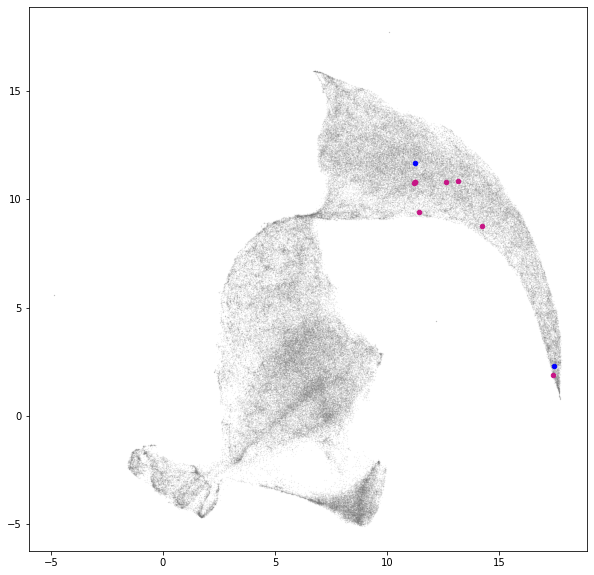

In [483]:
#VISUALIZE SELECTED PSS ON CREATURE
featurefile = '/usr/local/featureExtractionParty/models/pss_dictionary/V3features_embedded_new.pkl'
allfeatures_embedding = np.array(pd.read_pickle(featurefile))

plt.figure(figsize=(10,10))
#fig.patch.set_facecolor((1.0,1.0,1.0))
ax = plt.gca()
ax.set_facecolor((1.0,1.0,1.0))
plt.scatter(allfeatures_embedding[:,0],allfeatures_embedding[:,1],s=0.001,color='gray',alpha=0.9)

def loadfeatures(feat_files):
    features = []
    #synapse_distances = []
    index = 0
    for f in feat_files:
        index += 1
        v = np.loadtxt(f)
        features.append(v)
        #curdistfilename = f.replace('ae_model_v2.txt','distance.txt')
        #synapse_distances.append(np.loadtxt(curdistfilename))
    return features

directory = '/allen/programs/celltypes/workgroups/em-connectomics/analysis_group/segmentation/synapse_based/EXPT1/'
files = []
for i in sort_df.index:
    filenumber = sort_df['spine 1 index'][i]
    cur_file = directory + str(cell_id) + '/spine_' + str(filenumber) + '_ae_model_manualV3.txt'
    files.append(cur_file)
features = loadfeatures(files)
reducerfile = '/usr/local/featureExtractionParty/models/pss_dictionary/pss_umap_reducer.pkl'
reducer = pickle.load(open(reducerfile, 'rb'))
feature_embedding = reducer.transform(features)
for i in range (len(sort_df)):
    pss = [feature_embedding[i,0],feature_embedding[i,1]]
    pss = np.array(pss)
    pss = pss.reshape(1,-1)
    if sort_df['double headed'][sort_df.index[i]] == True:
        color = 'blue'
        opacity = 1
    elif sort_df['dually innervated'][sort_df.index[i]] == True:
        color = 'mediumvioletred'
        opacity = 1
    else:
        color = 'gray'
        opacity = 0
    plt.scatter(feature_embedding[i,0],feature_embedding[i,1],s=20.0,c=color,alpha=opacity)

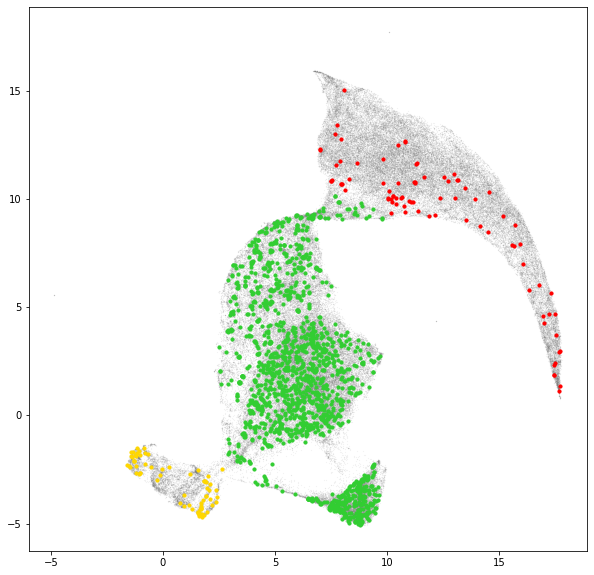

In [467]:
#VISUALIZE ALL PSS ON CREATURE
    
featurefile = '/usr/local/featureExtractionParty/models/pss_dictionary/V3features_embedded_new.pkl'
allfeatures_embedding = np.array(pd.read_pickle(featurefile))

plt.figure(figsize=(10,10))
#fig.patch.set_facecolor((1.0,1.0,1.0))
ax = plt.gca()
ax.set_facecolor((1.0,1.0,1.0))
plt.scatter(allfeatures_embedding[:,0],allfeatures_embedding[:,1],s=0.001,color='gray')

cell_directory = '/allen/programs/celltypes/workgroups/em-connectomics/analysis_group/segmentation/synapse_based/EXPT1/' + str(cell_id) + '/'
RES_FILES = glob.glob(cell_directory + '/spine*_ae_model_manualV3.txt')
features = loadfeatures(RES_FILES)
svc_file = open(r"/usr/local/featureExtractionParty/victoria_notebooks/svcrbfk.pkl","rb")
svc = pickle.load(svc_file)
svc_file.close()

reducerfile = '/usr/local/featureExtractionParty/models/pss_dictionary/pss_umap_reducer.pkl'
reducer = pickle.load(open(reducerfile, 'rb'))
feature_embedding = reducer.transform(features)
for i in range (len(feature_embedding)):
    pss = [feature_embedding[i,0],feature_embedding[i,1]]
    pss = np.array(pss)
    pss = pss.reshape(1,-1)
    color = ''
    if svc.predict((pss)) == '1':
        color = 'red'
    elif svc.predict((pss)) == '2':
        color = 'limegreen'
    else:
        color = 'gold'
    plt.scatter(feature_embedding[i,0],feature_embedding[i,1],s=10.0,c=color)